Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 41, 24)        456       
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 41, 24)        96        
_________________________________________________________________
activation (Activation)      (None, 60, 41, 24)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 20, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 20, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 20, 32)        6944      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 20, 32)        1

KeyboardInterrupt: 

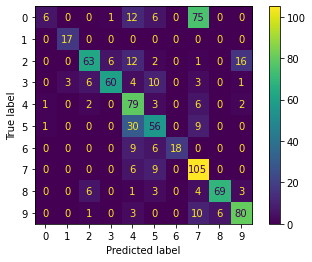

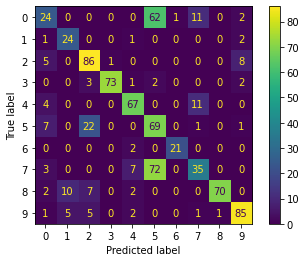

In [1]:
### Load necessary libraries ###
import glob
import os
import librosa
import librosa.display

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import ConfusionMatrixDisplay


### Define convolutional network architecture ###
def get_network():
    # num_filters = [24,32,64,128] 
    pool_size = (2, 2) 
    kernel_size = (3, 3)  
    input_shape = (60, 41, 2)
    num_classes = 10
    keras.backend.clear_session()
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(24, kernel_size,
                padding="same", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.Conv2D(32, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(keras.layers.Dropout(.2))
    
    model.add(keras.layers.Conv2D(64, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(keras.layers.Dropout(.2))
    
    model.add(keras.layers.Conv2D(128, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.GlobalMaxPooling2D())
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss=keras.losses.SparseCategoricalCrossentropy(), 
        metrics=["accuracy"])
        
    return model

model = get_network()
model.summary()

### Train and evaluate via 10-Folds cross-validation ###
accuracies = []
folds = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])
load_dir = "UrbanSounds8K/processed/"
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(folds):
    x_train, y_train = [], []
    for ind in train_index:
        # read features or segments of an audio file
        train_data = np.load("{0}/{1}.npz".format(load_dir,folds[ind]), 
                       allow_pickle=True)
        # for training stack all the segments so that they are treated as an example/instance
        features = np.concatenate(train_data["features"], axis=0) 
        labels = np.concatenate(train_data["labels"], axis=0)
        x_train.append(features)
        y_train.append(labels)

    # stack x,y pairs of all training folds 
    x_train = np.concatenate(x_train, axis = 0).astype(np.float32)
    y_train = np.concatenate(y_train, axis = 0).astype(np.float32)
    
    # for testing we will make predictions on each segment and average them to 
    # produce single label for an entire sound clip.
    test_data = np.load("{0}/{1}.npz".format(load_dir,
                   folds[test_index][0]), allow_pickle=True)
    x_test = test_data["features"]
    y_test = test_data["labels"]

    log_dir="logs/fit/" + folds[test_index][0]
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model = get_network()
    model.fit(x_train, y_train, epochs = 20, batch_size = 64, verbose = 1, validation_split=0.2,
                use_multiprocessing=True, workers=8, callbacks=[tensorboard_callback])
    
    # evaluate on test set/fold
    y_true, y_pred = [], []
    for x, y in zip(x_test, y_test):
        # average predictions over segments of a sound clip
        avg_p = np.argmax(np.mean(model.predict(x), axis = 0))
        y_pred.append(avg_p) 
        # pick single label via np.unique for a sound clip
        y_true.append(np.unique(y)[0]) 
    accuracies.append(accuracy_score(y_true, y_pred))    
    print("Fold n accuracy: {0}".format(accuracy_score(y_true, y_pred)))

    cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    cm.figure_.savefig('conf_mat_' + str(test_index) + '_acc_' + str(accuracy_score(y_true, y_pred)) + '.png',dpi=1000)    

print("Average 10 Folds Accuracy: {0}".format(np.mean(accuracies)))


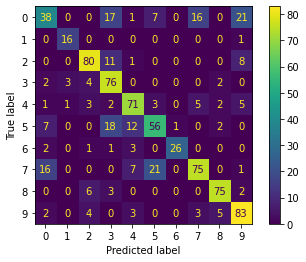

In [ ]:
# Training, eval accuracy
# Confusion matrix
# Review incorrect samples
train_index = str(1)
cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
cm.figure_.savefig('conf_mat_' + str(train_index) + '.png',dpi=1000)    


In [6]:
cm.figure_.savefig('conf_mat_' + str(test_index[0]) + '_acc_' + str(accuracy_score(y_true, y_pred)) + '.png',dpi=1000)    
test_index[0]

0